# Beauty Classifier


In [3]:
# !pip install wget

  Running setup.py bdist_wheel for wget ... done
  Stored in directory: /home/ubuntu/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget
You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


# Setup and Helpers

In [1]:
# Imports
%run ../src/utils/helpers.py

from collections import defaultdict
import requests
import boto3
import tempfile
import wget

import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from IPython.display import Image, display, clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# Initialization
s3 = boto3.resource('s3')
bucket_name = 'eye-of-the-needle'
bucket = s3.Bucket(bucket_name)

In [6]:
# Download pre-trained weights
# print('Beginning file download of pre-trained weights')
# url = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels.h5'  
# filepath = '../models/vgg16_weights.h5'
# wget.download(url, filepath)  

Beginning file download of pre-trained weights


'../models/vgg16_weights.h5'


Displaying images scored 1:
['2018/11/11/2018_1111_142000/thumbnail.jpg']


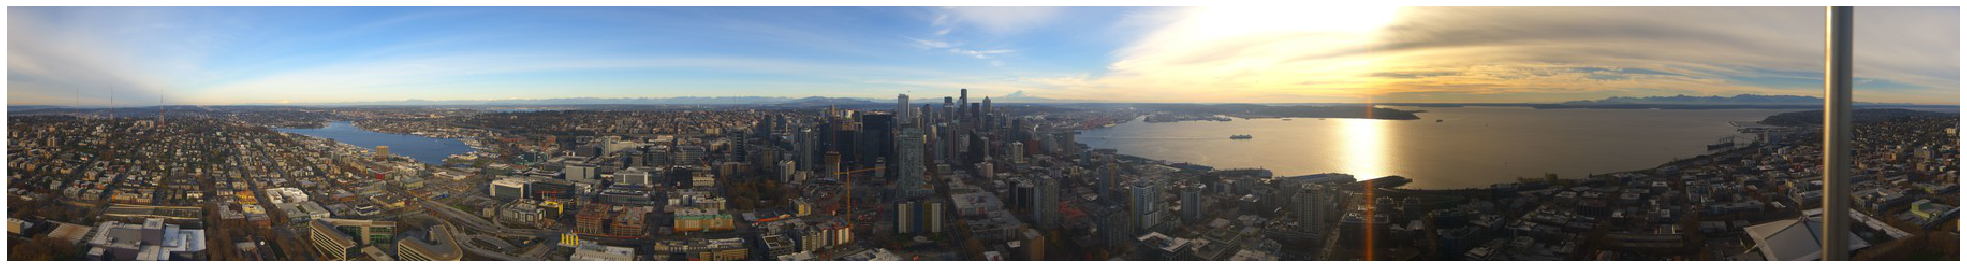

In [3]:
# Helper functions
record_path = '../data/raw/record.pkl'

@load_or_make(record_path, overwrite='n')
def get_record():
    record = defaultdict(dict)
    return record


def display_images(n, score=1):
    record = get_record()
    l = list(record.keys())

    n_files = []
    while len(n_files) < n:
        f = random.choice(l)
        if record[f]['score'] == score:
            n_files.append(f)

    print(f"\nDisplaying images scored {score}:")
    print(n_files)
    fig = plt.figure(figsize=(35, 12))
    for i, file in enumerate(n_files):
        obj = bucket.Object(file)
        tmp = tempfile.NamedTemporaryFile()
        with open(tmp.name, 'wb') as f:
            obj.download_fileobj(f)
            img=mpimg.imread(tmp.name)
        ax = fig.add_subplot(n, 1, i + 1) 
        ax.imshow(img)
        ax.axis('off')
    plt.subplots_adjust(wspace=0, hspace=0)
    # plt.show()
    return img
n = 1
img = display_images(n, 1)

In [4]:
img.shape

(237, 1820, 3)

# Explore Data

In [4]:
record_path = '../data/raw/record.pkl'

@load_or_make(record_path, overwrite='n')
def get_record():
    record = defaultdict(dict)
    return record

record = get_record()
scores = sum(v['score'] for k, v in record.items())
print(f"{scores} great photos out of {len(record.keys())} photos scored")

429 great photos out of 2032 photos scored


# Prep Data

In [76]:
dm = pd.DataFrame.from_dict(record, orient='index').reset_index().sort_values(by='index')

parse = lambda x: ''.join(x.split('/')[3].split('_'))[:-2]
date_strings = dm['index'].apply(parse)
filenames = date_strings + '.jpg'
dm['filename'] = filenames

dm['date'] = pd.to_datetime(date_strings, format='%Y%m%d%H%M', errors='ignore')
dm = dm.set_index(pd.DatetimeIndex(dm['date'])).drop('date', axis=1)
dm = dm.rename(columns={'index': 'filepath'})

# dm = dm.assign(filename = filenames)
dm.head()

,filepath,score,matches,filename
date,,,,
2017-06-15 09:30:00,2017/06/15/2017_0615_093000/thumbnail.jpg,0,1,201706150930.jpg
2017-06-15 14:30:00,2017/06/15/2017_0615_143000/thumbnail.jpg,0,1,201706151430.jpg
2017-06-15 16:50:00,2017/06/15/2017_0615_165000/thumbnail.jpg,0,1,201706151650.jpg
2017-06-16 07:00:00,2017/06/16/2017_0616_070000/thumbnail.jpg,1,1,201706160700.jpg
2017-06-16 14:30:00,2017/06/16/2017_0616_143000/thumbnail.jpg,0,1,201706161430.jpg


In [75]:
dm['filename'] = filenames
dm.head()

,filepath,score,matches,filename
date,,,,
2017-06-15 09:30:00,2017/06/15/2017_0615_093000/thumbnail.jpg,0,1,NaN
2017-06-15 14:30:00,2017/06/15/2017_0615_143000/thumbnail.jpg,0,1,NaN
2017-06-15 16:50:00,2017/06/15/2017_0615_165000/thumbnail.jpg,0,1,NaN
2017-06-16 07:00:00,2017/06/16/2017_0616_070000/thumbnail.jpg,1,1,NaN
2017-06-16 14:30:00,2017/06/16/2017_0616_143000/thumbnail.jpg,0,1,NaN


In [30]:
# d = ''.join(dm['index'][0].split('/')[3].split('_'))
# ''.join([d[0], d[1], d[2], d[3][-6:-2]])


,filepath,score
date,,
2017-06-15 09:30:00,2017/06/15/2017_0615_093000/thumbnail.jpg,0
2017-06-15 09:30:00,2017/06/15/2017_0615_143000/thumbnail.jpg,0
2017-06-15 09:30:00,2017/06/15/2017_0615_165000/thumbnail.jpg,0
2017-06-15 09:30:00,2017/06/16/2017_0616_070000/thumbnail.jpg,1
2017-06-15 09:30:00,2017/06/16/2017_0616_143000/thumbnail.jpg,0


## Move train/test/validation files into their own directories

In [ ]:
import os
s3_key = 'first-level/1456753904534/part-00014'
filename = os.path.basename(s3_key) 
foldername = os.path.dirname(s3_key)

# if you are not using conventional delimiter like '#' 
s3_key = 'first-level#1456753904534#part-00014
filename = s3_key.split("#")[-1]

In [ ]:
    
    for i, file in enumerate(n_files):
        obj = bucket.Object(file)
        tmp = tempfile.NamedTemporaryFile()
        with open(tmp.name, 'wb') as f:
            obj.download_fileobj(f)
            img=mpimg.imread(tmp.name)

## Extract features from convolutional base

In [ ]:


# Extract features
import os, shutil
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 32

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 512))  # Must be equal to the output of the convolutional base
    labels = np.zeros(shape=(sample_count))
    # Preprocess data
    flow_from_dataframe(dm, 
                        directory=None, 
                        x_col='filepath', 
                        y_col='score', 
                        target_size=(img_width, img_height),
                        class_mode='binary', 
                        batch_size=batch_size)

    generator = datagen.flow_from_directory(directory,
                                            target_size=(img_width,img_height),
                                            batch_size = batch_size,
                                            class_mode='binary')
    # Pass data through convolutional base
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels
    
train_features, train_labels = extract_features(train_dir, train_size)  # Agree with our small dataset size
validation_features, validation_labels = extract_features(validation_dir, validation_size)
test_features, test_labels = extract_features(test_dir, test_size)
view rawextract_features hosted with ❤ by GitHub


# Classifier

In [27]:
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception
from keras.applications.imagenet_utils import decode_predictions

Using TensorFlow backend.


In [13]:

# note we exclude the final dense layers and add one back below, we would retrain it ourselves
base_model = Xception(weights='imagenet', include_top=False, input_shape=(237, 1820, 3)) 
 
# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False
    
x = base_model.output
x = Flatten()(x) # flatten from convolution tensor output 
predictions = Dense(2, activation='softmax')(x) # should match # of classes predicted

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

## Non-recommended method

In [25]:
import os
import wget

In [ ]:
weight_file = '../models/vgg16_weights.h5'

if not os.path.exists(weight_file):
    # Download pre-trained weights
    print('Beginning file download of pre-trained weights')
    url = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels.h5'  
    filepath = '../models/vgg16_weights.h5'
    wget.download(url, filepath)  
#     raise FileNotFoundError("No file {weight_file} found. Check path again".format(weight_file))
